<div align="center">

<font size="5">

Laboratorium z przedmiotu: \
**Głębokie uczenie i analiza obrazów**

Ćwiczenie 5: \
**Generacja obrazów z wykorzystaniem GAN**

</font>

\
Marta Szarmach \
Zakład Telekomunikacji Morskiej \
Wydział Elektryczny \
Uniwersytet Morski w Gdyni

10.2023
</div>



# 1. Wprowadzenie

**Generacją obrazów** nazywamy problem tworzenia przez model nowych, nieistniejących wcześniej obrazów. Realizowana jest ona przez modele generatywne, które potrafią na podstawie obrazków z zestawu treningowego $x$ wyznaczać/aproksymować funkcję gęstości prawdopodobieństwa $p(x)$, najczęściej są to modele realizujące uczenie nienadzorowane (nie ma potrzeby dostarczania do modelu etykiet $y$). Generacja obrazów znajduje zastosowanie w takich zadaniach, jak rekonstrukcja obrazów, wspomaganie pracy projektantów (np. odzieży) czy edycja obrazów w grafice komputerowej.

Spośród różnych metod generacji obrazów z wykorzystaniem sieci neuronowych, można wymienić:
* **VAE** (ang. *Variational AutoEncoder*) - model, który wykorzystuje jedną sieć neuronową (nazywaną enkoderem) do zakodowania reprezentacji obrazów $x$ w przestrzeni ukrytej (ang. *latent space*) $z$, a drugą sieć neuronową (nazywaną dekoderem) do próbkowania $z$ i odtwarzania z tej przestrzeni wygenenerowanych obrazów $\hat{x}$,
* **modele autoregresyjne** - model, który dokonuje predykcji zawartości pikseli na podstawie sąsiadujących z nimi innych pikseli,
* **GAN** (ang. *Generative Adversarial Network*) - na którym to modelu skupimy się w ramach dzisiejszego ćwiczenia.

<div align="center">

<img src='https://raw.githubusercontent.com/Argenni/GUiAO_lab/main/rys/09_gan.png'/>

<font size="1">Grafika: kdnuggets.com</font>
</div>

Działanie GANów opiera się na rywalizacji dwóch sieci neuronowych: **generatora**, który dokonując próbkowania z przestrzeni $z$ (szumu), generuje sztuczne dane, oraz **dyskryminatora**, który ma za zadanie dokonać klasyfikacji przesłanych doń danych: czy są sztuczne, czy prawdziwe. Generator $G$ chce przechytrzyć dyskryminator $D$, tworząc coraz bardziej realistyczne obrazki; trwa zatem swoista ,,zabawa w kotka i myszkę'' - im lepszy generator, tym lepszy musi być dyskryminator (i tak w kółko), co ostatecznie prowadzi do powstawania coraz lepszej jakości obrazków. W związku z tym, podczas treningu GANów, wykorzystuje się (w ogólności) poniższą funkcję kosztu:
\begin{equation*}
\min_G \max_D \textrm{E}_{x \sim p(x)}[\log(D(x))] + \textrm{E}_{z \sim p(z)}[\log(1-D(G(z)))]
\end{equation*} 
którą należy rozumieć następująco: dyskryminator (uczony zarówno na danych rzeczywistych, jak i wygenerowanych) chce maksymalizować prawdopodobieństwo, że dokona predykcji 1 dla danych rzeczywistych, a 0 dla wygenerowanych, podczas gdy generator (uczony tylko na danych rzeczywistych) chce minimalizować to drugie prawdopodobieństwo. 
<font size='2'>Do tej funkcji kosztu wrócimy  w odpowiedniej części ćwiczenia.</font>


# 2. Cel ćwiczenia

**Celem niniejszego ćwiczenia** jest zapoznanie się z budową i działaniem GANów poprzez implementację architektury generatora i dyskryminatora (w formie konwolucyjnej sieci neuronowej o niewielkiej ilości warstw) oraz przeprowadzenie ich treningu z wykorzystaniem biblioteki PyTorch i języka programowania Python.


# 3. Stanowisko laboratoryjne

Do wykonania niniejszego ćwiczenia niezbędne jest stanowisko laboratoryjne, składające się z komputera klasy PC z zainstalowanym oprogramowaniem:
* językiem programowania Python (w wersji 3.8),
* IDE obsługującym pliki Jupyter Notebook (np. Visual Studio Code z rozszerzeniem ipykernel).


# 4. Przebieg ćwiczenia
## Implementacja konwolucyjnego GANu z wykorzystaniem biblioteki PyTorch

Na początku wykonaj poniższy fragment kodu, aby zaimportować biblioteki niezbędne do wykonania poniższego ćwiczenia:
* **PyTorch** - biblioteka wspomagająca budowanie architektur sieci neuronowych, posiadająca wbudowane moduły odpowiadające różnym warstwom sieci neuronowych, automatyczne obliczanie gradientów (*autograd*) niezbędne do przeprowadzenia treningu sieci neuronowych,
* **NumPy** - biblioteka umożliwiająca wykonywanie wysoko zoptymalizowanych obliczeń matematycznych na objektach typu *numpy array* (wielowymiarowych tablic),
* **Matplotlib** - biblioteka wspomagająca wizualizację pracy czy analizę danych poprzez wyświetlanie wykresów,
* **Scikit-learn** - biblioteka zawierająca gotowe implementacje wielu algorytmów klasycznego uczenia maszynowego, a także zbiory danych czy metryki; tutaj skorzystamy ze zbioru danych z obrazkami przedstawiającymi ręcznie pisane cyfry - `datasets.load_digits`,
* **tqdm** - biblioteka wyświetlająca pasek postępu (niezbędna przy korzystaniu z Dataloader, kiedy chcemy automatycznie dzielić zestaw danych treningowych na mini-batche).

In [1]:
# ! python -m pip install torch==2.0.1
# ! python -m pip install numpy==1.22.3
# ! python -m pip install matplotlib==3.4.2
# ! python -m pip install scikit-learn==0.24.2
# ! python -m pip install tqdm==4.66.1

import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
from sklearn.datasets import load_digits
# (dla zachowania powtarzalności wyników)
np.random.seed(10) 
torch.manual_seed(10)

### Wczytanie i przygotowanie danych

Na początku przygotujmy dane, na których będziemy dziś pracować. Tym razem korzystać będziemy ze zbioru `digits`, zawierającego *num_samples* = 1797 1-kanałowych obrazków o rozmiarze 8x8, przedstawiających odręcznie pisane cyfry. Uruchom kod z poniższej komórki, aby:
* wczytać oryginalne dane z zestawu `digits` (`digits.images`) do zmiennej $X$,
* dokonać ich normalizacji - wartości w macierzach-obrazkach z zestawu `digits` są z zakresu 0-16, więc aby znormalizować dane, wystarczy podzielić je przez ich największą wartość (16), 
* przekształcić dane do formatu `torch.tensor`, aby były zrozumiałe dla PyTorcha; jednocześnie wyodrębniając w danych jako drugi wymiar ilość kanałów (w tym przypadku jest to 1): nasze dane wejściowe mają teraz kształt (*num_samples*, *num_channels*, *sample_size*, *sample_size*), gdzie *num_channels* = 1 (dla obrazów RGB byłoby to 3), *sample_size*=8,
* przekazać dane do obiektu DataLoader, który będzie w trakcie treningu dzielił je nam na mini-batche o wielkości 64 obrazków,
* wyświetlić przykładowe obrazki z danych wejściowych z wykorzystaniem metody `plt.imshow`.

Wymiary oryginalnych obrazków: torch.Size([1797, 1, 8, 8])


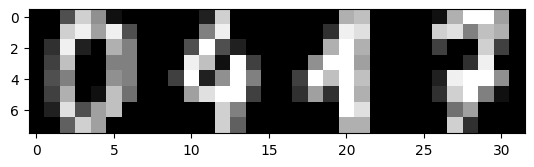

In [2]:
# --------------------------- Inicjalizacja ----------------------------
# Wczytanie danych
digits = load_digits()
X = digits.images
img_channels = 1 # ilość kanałów w generowanych obrazkach - w datasecie digits równa 1
# Przygotowanie danych
X = X/16 # normalizacja do zakresu 0-1
real = torch.tensor(X.reshape(-1, img_channels, X.shape[1], X.shape[2])) # przekształcenie w 1-kanałowy tensor
dataset = torch.utils.data.TensorDataset(real)
data_loader = torch.utils.data.DataLoader( # przekazanie do DataLoadera
    dataset, batch_size=64,
    shuffle=True, drop_last=True)
# Graficzna prezentacja danych
print("Wymiary oryginalnych obrazków: " + str(real.shape))
plt.imshow(np.concatenate((real[0][0],real[100][0],real[200][0], real[300][0]),axis=1), cmap='gray')

### Generacja szumu $z$

Na samym początku napiszemy funkcję `generate_noise`, której zadaniem jest losowe tworzenie ,,szumu'', na podstawie którego generowane będą później obrazy. Intuicyjnie, jeśli ,,zastartujemy'' działanie naszego GANu losowymi wartościami w próbce $z^{(i)}$, za każdym razem, kiedy generujemy obraz, możemy wygenerować coś nowego! Niech:
* $z$ próbkowane będzie z rozkładu normalnego $\mathcal{N}(0,1)$ - przyda się tu metoda `torch.randn` ([TUTAJ](https://pytorch.org/docs/stable/generated/torch.randn.html)).
* wygenerowany szum jest zapisany w postaci 4-wymiarowego tensora, w którym pierwszy wymiar decyduje o tym, ile próbek (obrazów) chcemy wygenerować (`num_samples`), drugi równy jest wstępnej ilości kanałów (`channels`), a dwa kolejne wynoszą 1 (aby były kompatybilne z późniejszymi konwolucjami - dwa ostatnie wymiary odpowiadają za szerokość i wysokość generowanych obrazków),
* wartości zwracanego tensora były w formacie float64 - zadbaj o właściwe ustawienie argumentu `dtype`.

In [3]:
def generate_noise(num_samples, channels):
    """
    Funkcja dokonująca generacji losowego szumu (z rozkładu normalnego N(0,1)), z którego generowane będą obrazy. \n
    Argumenty: \n
    - num_samples - ilość obrazów, które za pomocą tego szumu chcemgy wygenerować (skalar, int), \n
    - channels - wielkość próbki szumu (skalar, int) \n
    Zwraca: noise - torch tensor zawierający wygenerowany szum, shape=(num_samples, channels, 1, 1)
    """
    # --------- UZUPEŁNIJ KOD -----------------
    noise = torch.randn(size=(num_samples, channels, 1, 1), dtype=torch.float64)
    # ------------------------------------------
    return noise

Uruchom poniższy kod, aby zobaczyć, czy Twoja funkcja rzeczywiście zwraca losowe wartości w tensorze o właściwych rozmiarach:

In [4]:
noise_size = 64 # ilość kanałów, jakie będzie miał wygenerowany szum - nie zmieniaj tej wartości!
noise = generate_noise(4, noise_size) # Generacja szumu - takiego, by utworzyć 4 obrazki 
print("Wymiary wygenerowanego szumu: " + str(noise.shape))
print(noise[0:3,0:3,:,:])

Wymiary wygenerowanego szumu: torch.Size([4, 64, 1, 1])
tensor([[[[-0.7842]],

         [[ 1.0315]],

         [[-1.1703]]],


        [[[ 1.0729]],

         [[-1.1646]],

         [[-0.1311]]],


        [[[-0.1365]],

         [[-1.2744]],

         [[-0.5365]]]], dtype=torch.float64)


### Implementacja generatora

W kolejnym kroku zdefiniujemy strukturę pierwszego ze składników naszego GANu, a mianowicie generatora, korzystając z klas dostępnych w bibliotece PyTorch. Tak samo, jak dotychczas, storzymy własną klasę `Generator` (która musi dziedziczyć z klasy `torch.nn.Module`), w której umieścimy dwie metody:
* metodę-konstruktor `__init__()` - opisującą budowę naszeg generatora; skorzystamy tu ze znanych już wcześniej warstw `torch.nn.BatchNorm2d`, `torch.nn.ReLU`, czy `torch.nn.Sequential`, ale użyjemy także kilku nowych:
    * `torch.nn.ConvTranspose2d` - ([TUTAJ](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)) - realizująca operację odwrotną do konwolucji zwaną **konwolucją transponowaną** bądź też, mniej poprawnie, dekonwolucją; zapewnia upsampling, czyli zwiększanie wymiarów obrazka wraz z każdą warstwą, a wymaga takich argumentów, jak ,,zwykła'' warstwa konwolucyjna: ilość kanałów wejściowych/wyjściowych, wielkość filtra, *padding*, *stride*,
    * `torch.nn.Sigmoid` - ([TUTAJ](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)) - realizująca po prostu funkcję aktywacji Sigmoid.
* metodę `forward()` - w której określamy przepływ danych pomiędzy warstwami.

Uzupełnij zatem poniższy kod! Niech nasz generator składa się z następujących warstw:

2 x (`ConvTranspose2d` -> `BatchNorm2d` -> `ReLU`) -> `ConvTranspose2d` -> `Sigmoid`.
* Sigmoid na ostatniej warstwie ma zapewnić, że zwracane przez sieć wartości pikseli w generowanych obrazkach też mieszczą się w zakresie 0-1.
* Wartości hiperparametrów na warstwach dekonwolucyjnych tutaj zostały predefiniowane przeze mnie:
    * podczas pierwszej dekonwolucji, niech wyznaczonych zostanie 128 kanałów, a drugiej - 64, a po trzeciej - 1 (ilość kanałów przechowywana jest w tablicy `num_conv_channels`),
    * niech hiperparametr *padding* domyślnie wynosi 0, a *stride* 1 (w razie potrzeby, wartości te przekazywać będziemy konstruktorowi jako argumenty),
    * *kernel\_size* na kolejnych warstwach ustawiłam na sztywno na 2,4,4. 

<font size='2'>Wyjaśnienie: Po każdej dekonwolucji, wymiary obrazu (szerokość i długość) zmieniają się zgodnie z poniższym wzorem:
\begin{equation*}
    sample\_size_{\textrm{new}} = (sample\_size_{\textrm{original}} -1) \cdot stride - 2 \cdot padding  + kernel\_size
\end{equation*}
(jest to przekształcenie, niejako odwrotność wzoru na wymiary obrazu po zwykłej konwolucji). Jeśli wygenerujemy szum o wielkości 16x1x1, to:
* po pierwszej dekonwolucji (z *kernel_size* = 2 i *output_channels* = 128) wygenerowane zostaną obrazki o wielkości 128x2x2,
* po drugiej dekonwolucji (z *kernel_size* = 4 i *output_channels* = 64) wygenerowane zostaną obrazki o wielkości 64x5x5, 
* po ostatniej dekonwolucji (z *kernel_size* = 4 i *output_channels* równemu ilości kanałów w obrazkach z `digits`, a zatem 1) wygenerowane zostaną obrazki o wielkości 1x8x8 - takie same, jak w `digits`!</font>


In [5]:
class Generator(torch.nn.Module):
    """
    Model generatora wchodzącego w skład GANu:
    (ConvTranspose -> BatchNorm -> ReLU) -> (ConvTranspose -> BatchNorm -> ReLU) -> (ConvTranspose -> Sigmoid)
    """
    
    def __init__(self, input_channels, output_channels, padding=0, stride=1):
        """
        Definiuje budowę sieci. Argumenty: \n
        - input_channels - ilość kanałów w wejściowych obrazkach (skalar, int), \n
        - output_channel - ilość kanałów w wyjściowych obrazkach (skalar, int), \n
        - padding - (opcjonalnie) ,,grubość'' ramki z zer dodowananej do obrazka (skalar, int, domyślnie 0) \n
        - stride - (opcjonalnie) co ile pikseli obrazka wykonywana jest konwolucja (skalar, int, domyślnie 1).
        """
        super().__init__()
        num_conv_channels = [128, 64] # ilość kanałów po kolejnych dekonwolucjach
        kernel_sizes = [2, 4, 4] # wielkości filtra przy kolejnych dekonwolucjach
        # ---------------------- UZUPEŁNIJ KOD -----------------------------------
        # size1 = (sample_size - 1)*stride - 2*padding + kernel_size
        # ()
        # Zacznij definiować budowę sieci:
        self.first_layer = torch.nn.Sequential(
            # ConvTranspose2d
            torch.nn.ConvTranspose2d(
                in_channels=input_channels,
                out_channels=num_conv_channels[0],
                kernel_size=kernel_sizes[0],
                padding=padding,
                stride=stride
            ),
            # BatchNorm2d
            torch.nn.BatchNorm2d(num_features=num_conv_channels[0]),
            # Funkcja aktywacji ReLU
            torch.nn.ReLU()
        )
        self.second_layer = torch.nn.Sequential(
            # ConvTranspose2d
            torch.nn.ConvTranspose2d(
                in_channels=num_conv_channels[1],
                out_channels=num_conv_channels[1],
                kernel_size=kernel_sizes[1],
                padding=padding,
                stride=stride
            ),
            # BatchNorm2d
            torch.nn.BatchNorm2d(num_features=num_conv_channels[1]),
            # Funkcja aktywacji ReLU
            torch.nn.ReLU()
        )
        self.third_layer = torch.nn.Sequential(
            # ConvTranspose2d
            torch.nn.ConvTranspose2d(
                in_channels=num_conv_channels[1],
                out_channels=output_channels,
                kernel_size=kernel_sizes[2] * 2,
                padding=padding,
                stride=stride
            ),
            # Sigmoid
            torch.nn.Sigmoid()
        )
        # ---------------------------------------------------------------------

    def forward(self, noise):
            """ 
            Definiuje przepływ danych w sieci. \n
            Argument: noise - dane wejściowe, torch.tensor zawierający szum, z którego generowany ma być obraz, shape=(num_samples, input_channels, 1, 1) \n
            Zwraca: fake - odpowiedź sieci w postaci wygenerowanych obrazów, torch.tensor, shape=(sum_samples, num_channels, sample_size, sample_size)
            """
            # ------------------- UZUPEŁNIJ KOD ----------------
            fake = self.first_layer(noise)
            fake = self.second_layer(noise)
            fake = self.third_layer(noise)
            # --------------------------------------------------
            return fake

Spróbujmy wygenerować kilka obrazków z pomocą niewytrenowanego generatora - tylko po to, by sprawdzić, czy wszystko działa i czy wymiary generowanych tensorów się zgadzają. Uruchom więc kod z poniższej komórki, aby utworzyć obiekt stworzonej przez nas klasy `Generator` i wykonać jakiś próbny *forward pass* na wygenerowanym wcześniej szumie `noise`. Wygenerowany tensor powinien mieć wymiary 4x1x8x8, a rysunek... cóż, na razie będzie wyglądał po prostu jak szum!

Wymiary wygenerowanych obrazków: torch.Size([4, 1, 8, 8])


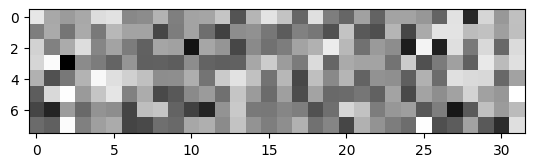

In [6]:
gen = Generator(noise_size, img_channels) # inicjalizacja generatora
gen = gen.double()
fake = gen(noise) # generacja obrazków
print("Wymiary wygenerowanych obrazków: " + str(fake.shape))
fake_np = fake.detach().numpy()
plt.imshow(np.concatenate((fake_np[0][0],fake_np[1][0],fake_np[2][0],fake_np[3][0]),axis=1), cmap='gray')

### Implementacja dyskryminatora

Pora na zdefiniowanie budowy kolejnej nieodzownej części GANu - dyskryminatora! Niech nasz dyskryminator składa się z następujących warstw:

2 x (`Conv2d` -> `BatchNorm2d` -> `LeakyReLU`) -> `Conv2d` -> `Sigmoid`.

Można zauważyć, że jest to architektura bardzo podobna do definiowanego chwilę wcześniej generatora - tyle, że w miejscu warstw dekonwolucyjnych mamy zwykłe konwolucje (nie zależy tu nam na upsamplingu), a w miejscu funkcji aktywacji ReLU - LeakyReLU ([TUTAJ](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)) (co ma zapewnić większą stabilność treningu). Wyjściowa funkcja aktywacji Sigmoid ma zapewnić binarną klasyfikację analizowanego obrazka - jako rzeczywistego (1) bądź wygenerowanego sztucznie (0).

Spróbuj (na bazie tego, co napisałam w opisie generatora), sam dobrać wielkości filtrów na kolejnych warstwach konwolucyjnych, aby w wyniku konwolucji pierwotnie obrazków o kształcie (*num_samples*, *input_channels*, 8, 8) otrzymać tensor (*num_samples*, 1, 1, 1), który ostatecznie (w wyniku funkcji `torch.squeeze` w instrukcji `return` metody `forward`) zostanie ,,spłaszczony'' do postaci (*num_samples*,)!



In [7]:
class Discriminator(torch.nn.Module):
    """
    Model dyskryminatora wchodzącego w skład GANu:
    2x (Conv2d -> BatchNorm -> LeakyReLU) -> (Conv2d -> Sigmoid)
    """
    
    def __init__(self, input_channels, output_channels, padding=0, stride=1):
        """
        Definiuje budowę sieci. Argumenty: \n
        - input_channels - ilość kanałów w wejściowych obrazkach (skalar, int), \n
        - output_channel - ilość kanałów w wyjściowych obrazkach (skalar, int), \n
        - padding - ,,grubość'' ramki z zer dodowananej do obrazka (skalar, int, domyślnie 0), \n
        - stride - co ile pikseli obrazka wykonywana jest konwolucja (skalar, int, domyślnie 1).
        """
        super().__init__()
        num_conv_channels = [128, 64] # ilość kanałów po kolejnych konwolucjach
        # ---------------------- UZUPEŁNIJ KOD -----------------------------------
        kernel_sizes = [2, 4, 8] # wielkości filtra przy kolejnych konwolucjach
        
        # Zacznij definiować budowę sieci:
        self.first_layer = torch.nn.Sequential(
            # Conv2d
            torch.nn.Conv2d(
                in_channels=input_channels,
                out_channels=num_conv_channels[0],
                kernel_size=kernel_sizes[0],
                padding=padding,
                stride=stride
            ),
            # BatchNorm2d
            torch.nn.BatchNorm2d(num_features=num_conv_channels[0]),
            # Funkcja aktywacji LeakyReLU
            torch.nn.LeakyReLU() 
        )
        self.second_layer = torch.nn.Sequential(
            # Conv2d
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=num_conv_channels[0],
                kernel_size=kernel_sizes[1],
                padding=padding,
                stride=stride
            ),
            # BatchNorm2d
            torch.nn.BatchNorm2d(num_features=num_conv_channels[0]),
            # Funkcja aktywacji LeakyReLU
            torch.nn.LeakyReLU() 
        )
        self.third_layer = torch.nn.Sequential(
            # Conv2d
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=output_channels,
                kernel_size=kernel_sizes[2],
                padding=padding,
                stride=stride
            ),
            # Sigmoid
            torch.nn.Sigmoid()
        )
        # ---------------------------------------------------------------------

    def forward(self, images):
            """ 
            Definiuje przepływ danych w sieci. \n
            Argument: images - dane wejściowe, torch.tensor zawierający obrazki do analizy, shape=(sum_samples, num_channels, sample_size, sample_size) \n
            Zwraca: out - odpowiedź sieci: 0 (obrazek fałszywy) - 1 (obrazek prawdziwy), torch.tensor, shape=(sum_samples,)
            """
            # ------------------- UZUPEŁNIJ KOD ----------------
            out = self.first_layer(images)
            out = self.second_layer(images)
            out = self.third_layer(images)
            # --------------------------------------------------
            return torch.squeeze(out)

Kod z poniższej komórki pozwoli nam sprawdzić poprawność implementacji naszego dyskryminatora. Po utworzeniu obiektu klasy `Discriminator`, sprawdzimy, jak klasyfikuje on kilka wygenerowanych wcześniej obrazków (przechowywanych w zmiennej `fake`), a także kilka rzeczywistych, ze zbioru `digits` (przechowywanych jako `real`). Ponownie, nie spodziewajmy się spektakularnych wyników - nasz dyskryminator nie został jeszcze wcale wytrenowany (sprawdzamy jedynie poprawność kodu), jego decyzje są póki co zupełnie losowe (dokładność na poziomie 50%.)

In [8]:
disc = Discriminator(img_channels, 1) # inicjalizacja dyksryminatora
disc = disc.double()
pred = np.round(disc(fake).detach().numpy()) # predykcje dyskryminatora na danych (wcześniej) wygenerowanych 
accuracy = np.mean(pred == np.zeros_like(pred)) * 100

print("Wymiary wygenerowanych obrazków: " + str(pred.shape))
print("Dokładność zainicjowanego dyskryminatora na wygenerowanych obrazkach: " + str(accuracy) + "%")
real_batch = real[0:4,:,:,:]
pred = np.round(disc(real_batch).detach().numpy()) # predykcje dyskryminatora na danych rzeczywistych 
accuracy = np.mean(pred == np.ones_like(pred)) * 100
print("Dokładność zainicjowanego dyskryminatora na rzeczywistych obrazkach: " + str(accuracy) + "%")

Wymiary wygenerowanych obrazków: (4,)
Dokładność zainicjowanego dyskryminatora na wygenerowanych obrazkach: 0.0%
Dokładność zainicjowanego dyskryminatora na rzeczywistych obrazkach: 100.0%


### Trening

Pozostała ostatnia, natrudniejsza w tym ćwiczeniu część: napiszmy funkcję `train_GAN()`, w której przeprowadzimy trening naszgo GANu. 

* Wykorzystajmy, podobnie, jak poprzednio, algorytm optymalizacji Adam - tym razem jednak będziemy musieli utworzyć nie jeden, a dwa obiekty związane z tym algorytmem - jeden dokonujący optymalizacji parametrów generatora (tworzymy obiekt klasy `Generator` o nazwie `gen`), a drugi - dyskryminatora (tworzymy obiekt klasy `Discriminator` o nazwie `disc`). Hiperparametry niezbędne do działania tego algorytmu mamy podane przeze mnie:
    * stała uczenia $\alpha$ (zmienna i argument `lr`) będzie miała wartość 0,002,
    * współczynniki $\Beta_1$ i $\Beta_2$ (zmienna i argument `betas`) będą miały wartość odpowiednio 0,999 i 0.5,
    * nie używamy regularyzacji (nic nie przekazujemy jako argument `weight_decay`).
* Rzeczywistych obrazków (w zmiennej `real[0]`) dostarcza nam w kolejnych iteracjach obiekt klasy `DataLoader`.
* Nie wykorzystamy żadnych gotowych funkcji obliczających wartość kosztu - musimy napisać własną! Do treningu GANów, wykorzystuje się następująco opisanymi funkcjami kosztu:
    * dyskryminator chce minimalizować szansę na to, że obrazki podsyłane mu przez generator zostaną przez niego ocenione jako prawdziwe, a jednocześnie maksymalizować szanse na to, że ,,przepuści'' rzeczywiste obrazki - musimy więc optymalizować wyrażenie:
    \begin{equation*}
        J_d = -\frac{1}{m} [\log(D(x^{(i)})) + \log(1-D(G(z^{(i)}))) ]
    \end{equation*}
    * generator chce maksymalizować szanse na to, że dyskryminator oceni wygenerowane przez niego obrazki jako prawdziwe - należy więc optymalizować wyrażenie: 
    \begin{equation*}
        J_g = -\frac{1}{m} \log(D(G(z^{(i)})))
    \end{equation*}
    W powyższych wyrażeniach:
    * $m$ oznacza ilość obrazków w mini-batchu (przechowywana jako pole `batch_size` obiektu klasy `DataLoader`),
    * $G(z^{(i)})$ to sztuczny obrazek wygenerowany przez generator z próbki szumu $z^{(i)}$
    * $D(x^{(i)})$ to odpowiedź dyskryminatora na $i$-tą próbkę rzeczywistych danych, a $D(G(z^{(i)}))$ - jego odpowiedź na sztuczny obrazek.
* Pozostałe elementy są podobne jak w poprzednich ćwiczeniach: należy przestawić sieci w tryb treningu, przeprowadzamy *forward pass* (tutaj musimy najpierw wygenerować `noise` - próbki szumu $z^{(i)}$ z pomocą funkcji `generate_noise`, następnie obliczyć $G(z^{(i)})$, wywołując `gen` z tą próbką, otrzymując w tej sposób sztuczne obrazki `fake`, a potem możemy obliczyć `pred_fake` $D(G(z^{(i)}))$, tj. dokonać ich oceny przez dyskryminator, wywołując `disc`), obliczamy wartości funkcji kosztu, zerujemy gradienty (`.zero_grad()`), wykonujemy propagację wsteczną ( `.backward()`) oraz wywołujemy jedną iterację algorytmu optymalizacji (`.step()`).

In [9]:
from torch.autograd import Variable

def train_GAN(data_loader, img_channels, noise_size):
    """
    Wykonaj trening GANu na zadanych danych wejściowych i z określonymi ilościami kanałów. \n
    Argumenty: \n
    - data_loader - obiekt klasy torch.utils.data.DataLoader, zawierający dane treningowe i dzielący je na mini-batche, \n
    - img_channels - ilość kanałów w docelowych generowanych obrazkach (skalar, int), \n
    - noise_size - wielkość próbki szumu (niezbędny do uruchomienia generate_noise), (skalar, int). \n
    Zwraca: gen - wytrenowana sieć neuronowa zdefiniowanej wcześniej klasy Generator.
    """
    # Niezbędne zmienne
    step = 0 # inicjalizacja zmiennej zliczającej ilość dokonanych aktualizacji parametrów
    lr = 0.0002 # stała uczenia (wymagane przez Adam)
    betas = (0.5, 0.999) # bety dla Adam
    gen = Generator(noise_size, img_channels) # Inicjalizacja generatora
    gen = gen.double()
    disc = Discriminator(img_channels, 1) # Inicjalizacja dyksryminatora
    disc = disc.double()
    # ---------------------------- UZUPEŁNIJ KOD -------------------------------------------------------------------
    # Utwórz obiekty związane z metodą optymalizacji - Adam - dla generatora i dyskryminatora
    optimizer_gen = torch.optim.Adam(params=gen.parameters(), lr=lr, betas=betas)
    optimizer_disc = torch.optim.Adam(params=disc.parameters(), lr=lr, betas=betas)
    # Przełącz obie sieci neuronowe w tryb treningu
    gen.train()
    disc.train()
    for i in range(200):
        for real in tqdm.tqdm(data_loader):
            step = step + 1
            # Wygeneruj szum, który posłuży do generacji obrazów - tyle próbek, ile ma zestaw rzeczywistych obrazków
            noise = generate_noise(real[0].shape[0], noise_size)
            # Wykonaj forward pass na generatorze - wygeneruj obrazy na podstawie wcześniejszego noise
            fake = gen(noise)

            # Optymalizacja dyskryminatora
            # a) Oblicz predykcje na obrazach wygenerowanych
            # (zrób .detach() na pred_fake, aby generator nie był zmieniany)
            pred_fake = disc(fake).detach()
            # b) Oblicz predykcje na obrazach rzeczywistych
            pred_real = disc(real[0])
            # c) Oblicz koszt dyskryminatora
            loss_disc = (torch.log(pred_real) + torch.log(1 - pred_fake)) / (-data_loader.batch_size)
            # f) Wyzeruj gradienty dla dyskryminatora
            disc.zero_grad()
            # d) Wykonaj propagację wsteczną kosztu - uwaga, należy wymusić zachowanie obliczeń, przekazując retain_graph=True
            loss_disc = loss_disc.max()
            loss_disc.backward()
            # e) Wykonaj 1 iterację algorytmu optymalizacji dla dyskryminatora
            optimizer_disc.step()

            # Optymalizacja generatora
            # a) Oblicz koszt na obrazach wygenerowanych
            pred_fake = disc(fake)
            loss_gen = torch.log(pred_fake) / (-data_loader.batch_size)
            # d) Wyzeruj gradienty dla dyskryminatora
            optimizer_gen.zero_grad()
            # b) Wykonaj propagację wsteczną kosztu
            loss_gen = loss_gen.min()
            loss_gen.backward(retain_graph=True)
            # c) Wykonaj 1 iterację algorytmu optymalizacji dla dyskryminatora
            optimizer_gen.step()
            # ----------------------------------------------------------------------------------------------------
            if step%1000==0: # Co pewien czas sprawdź jakość treningu
                print("Iteracja " + str(step) + ":")
                print(" Koszt generatora: " + str(loss_gen))
                print(" Koszt dyskryminatora: " + str(loss_disc))
                fake = fake.detach().numpy()
                plt.figure()
                plt.imshow(np.concatenate((fake[0][0],fake[1][0],fake[2][0], fake[3][0]),axis=1), cmap='gray')
                plt.show(block=False)
    return gen

Dokonajmy zatem treningu naszego GANu! Aby mieć podgląd na to, jak przebiega trening, co pewien czas wyświetlane będą wartości kosztu zarówno dla generatora, jak i dyskryminatora, a także próbka generowanych na ten moment obrazków. Im dłuższy trening, tym bardziej obrazki powinny przypominać ręcznie pisane cyferki, jak w zestawie `digits`, a nie szum. 

Podziwiaj obrazki otrzymywane pod sam koniec treningu!

 64%|██████▍   | 18/28 [00:01<00:00, 19.11it/s]

Iteracja 1000:
 Koszt generatora: tensor(0.0009, dtype=torch.float64, grad_fn=<MinBackward1>)
 Koszt dyskryminatora: tensor(0.0472, dtype=torch.float64, grad_fn=<MaxBackward1>)


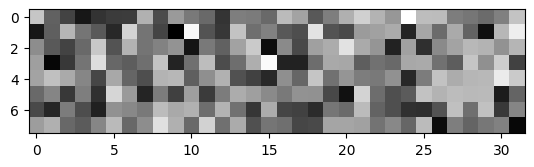

 36%|███▌      | 10/28 [00:00<00:01, 16.15it/s]

Iteracja 2000:
 Koszt generatora: tensor(0.0001, dtype=torch.float64, grad_fn=<MinBackward1>)
 Koszt dyskryminatora: tensor(0.0785, dtype=torch.float64, grad_fn=<MaxBackward1>)


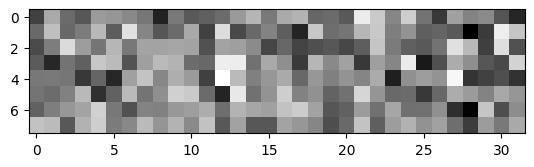

  7%|▋         | 2/28 [00:00<00:02, 12.78it/s]

Iteracja 3000:
 Koszt generatora: tensor(3.5159e-05, dtype=torch.float64, grad_fn=<MinBackward1>)
 Koszt dyskryminatora: tensor(0.0955, dtype=torch.float64, grad_fn=<MaxBackward1>)


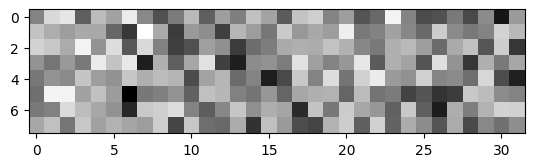

 79%|███████▊  | 22/28 [00:01<00:00, 19.26it/s]

Iteracja 4000:
 Koszt generatora: tensor(1.3721e-05, dtype=torch.float64, grad_fn=<MinBackward1>)
 Koszt dyskryminatora: tensor(0.1101, dtype=torch.float64, grad_fn=<MaxBackward1>)


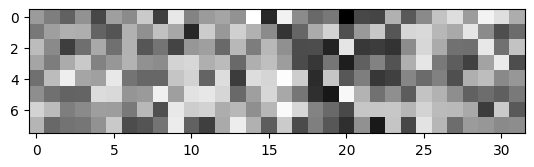

 50%|█████     | 14/28 [00:00<00:00, 18.86it/s]

Iteracja 5000:
 Koszt generatora: tensor(5.5844e-06, dtype=torch.float64, grad_fn=<MinBackward1>)
 Koszt dyskryminatora: tensor(0.1243, dtype=torch.float64, grad_fn=<MaxBackward1>)


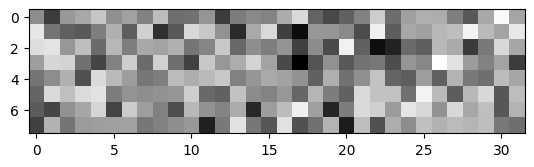

100%|██████████| 28/28 [00:01<00:00, 17.74it/s]


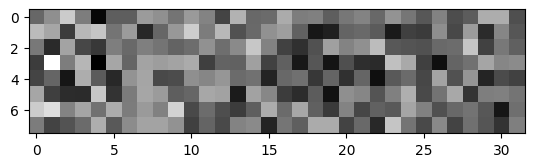

In [10]:
# ----------------- Trening ------------------------
gen = train_GAN(data_loader, img_channels, noise_size)
# Prezentacja wygenerowanych obrazków po treningu
fake = gen(noise).detach().numpy()
plt.imshow(np.concatenate((fake[0][0],fake[1][0],fake[2][0], fake[3][0]),axis=1), cmap='gray')

## 5. Pytania kontrolne
1. Opisz rolę generatora jako składnika GANów.
2. Opisz rolę dyskryminatora jako składnika GANów.
3. Jak pokrótce wygląda trening GANów?

1. **Generator w GAN**:
   - Generuje nowe przykłady danych, na przykład obrazy, przy użyciu losowych wejść.
   - Jego celem jest stworzenie danych, które są trudne do odróżnienia od rzeczywistych przez dyskryminatora.
   - Stara się zminimalizować błąd, czyli różnicę między wygenerowanymi danymi a prawdziwymi danymi.
   - Uczony na próbkach x.
2. **Dyskryminator w GAN**:
   - Ocenia, czy dany przykład danych jest prawdziwy (rzeczywisty) czy wygenerowany przez generator.
   - Jego celem jest poprawne rozróżnianie między prawdziwymi danymi a tymi stworzonymi przez generator.
   - Stara się zminimalizować błąd, czyli różnicę między swoją oceną a rzeczywistym stanem.
   - Uczony zarówno na prawdziwych jak i sztucznych próbkach.
3. **Trening GAN**:
   - dyskryminator i generator trenowane są jednocześnie
   - Generator generuje fałszywe przykłady danych (szum).
   - Dyskryminator ocenia prawdziwość rzeczywistych i wygenerowanych danych.
   - Dyskryminator otrzymuje informację zwrotną o tym, jak dobrze rozróżnia między prawdziwymi a fałszywymi danymi.
   - Generator otrzymuje informację zwrotną od dyskryminatora dotyczącą jakości wygenerowanych danych.
   - Proces iteracyjny powtarza się, a modele są trenowane na przemian, dążąc do osiągnięcia równowagi, gdzie generator tworzy wiarygodne dane, a dyskryminator jest skuteczny w ich rozróżnianiu.
   - GAN osiąga najniższą wartość kosztu, gdy dane generowane przez generator mają rozkład możliwie zbliżony do danych treningowych: p(^x) mniej więcej równy p(x)